In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import os
from imageio.v3 import imread

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import time

try:
    from helper_functions import train_simple_network
except:
    import requests
    with open("helper_functions.py", "wb") as f:
        r = requests.get('https://raw.githubusercontent.com/Morshedy22/Inside-Deep-Learning-Book-Solutions/refs/heads/main/helper_functions.py')
        f.write(r.content)
    from helper_functions import train_simple_network

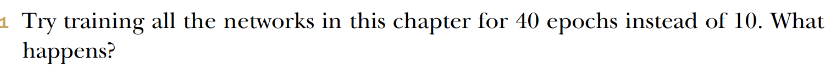

In [8]:
""" 
train for 20 epochs results
cnn_results['train Accuracy'] -> 92.55
cnn_results['test Accuracy'] -> 92.80000000000001
fc_results['train Accuracy'] -> 90.16166666666666
fc_results['test Accuracy'] -> 90.66
cnn_results_with_pool['train Accuracy'] -> 0.9518666666666666
cnn_results_with_pool['test Accuracy'] -> 0.9533
cnn_results_with_pool_augmented['train Accuracy'] -> 0.9623
cnn_results_with_pool_augmented['test Accuracy'] -> 0.9773


train for 40 epochs results
cnn_results['train Accuracy'] -> 94.81
cnn_results['test Accuracy'] -> 94.54
fc_results['train Accuracy'] -> 92.235
fc_results['test Accuracy'] -> 92.49000000000001
cnn_results_with_pool['train Accuracy'] -> 0.9725166666666667
cnn_results_with_pool['test Accuracy'] -> 0.9737
cnn_results_with_pool_augmented['train Accuracy'] -> 0.9753333333333334
cnn_results_with_pool_augmented['test Accuracy'] -> 0.9859

observations and what happens 
the main oversvation the accuracy is increased for all models
"""

" \ntrain for 20 epochs results\ncnn_results['train Accuracy'] -> 92.55\ncnn_results['test Accuracy'] -> 92.80000000000001\nfc_results['train Accuracy'] -> 90.16166666666666\nfc_results['test Accuracy'] -> 90.66\ncnn_results_with_pool['train Accuracy'] -> 0.9518666666666666\ncnn_results_with_pool['test Accuracy'] -> 0.9533\ncnn_results_with_pool_augmented['train Accuracy'] -> 0.9623\ncnn_results_with_pool_augmented['test Accuracy'] -> 0.9773\n\n\ntrain for 40 epochs results\ncnn_results['train Accuracy'] -> 94.81\ncnn_results['test Accuracy'] -> 94.54\nfc_results['train Accuracy'] -> 92.235\nfc_results['test Accuracy'] -> 92.49000000000001\ncnn_results_with_pool['train Accuracy'] -> 0.9725166666666667\ncnn_results_with_pool['test Accuracy'] -> 0.9737\ncnn_results_with_pool_augmented['train Accuracy'] -> 0.9753333333333334\ncnn_results_with_pool_augmented['test Accuracy'] -> 0.9859\n\nobservations and what happens \nthe main oversvation the accuracy is increased for all models\n"

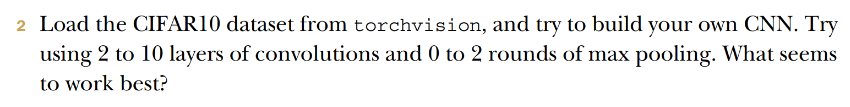

In [ ]:
# make a grid serach to know what is the best number of layers and best number max pooling
# in chapter 5 there's tool name optuna can make it faster than grid search to know the value of best hyperparamter

train_dataset = torchvision.datasets.CIFAR10("data", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.CIFAR10("data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(train_dataset, batch_size=128, num_workers=4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def CNNLayer(in_channels, out_channels, kerenel_size):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, kerenel_size, padding='same'), 
                         nn.Tanh())

class CNNModel(nn.Module):
    def __init__(self, numOfinChannels, numOfClasses, num_layers, num_maxPooling):
        super().__init__()
        
        self.num_maxPooling = num_maxPooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=numOfinChannels, out_channels=32, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
    
        rng = num_layers
        if num_maxPooling:
            rng = num_layers//num_maxPooling
        self.layer2 = nn.Sequential(
            *[CNNLayer(32, 32, 3) for _ in range(rng)],
        )
        self.layer3 = nn.Sequential(
            CNNLayer(32, 128, 3),
            *[CNNLayer(128, 128, 3) for _ in range(rng)],
        )

        self.layer4 = nn.Sequential(
            CNNLayer(128, 512, 3),
            *[CNNLayer(512, 512, 3) for _ in range(rng)],
        )

        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*32*32, out_features=numOfClasses)
        )

    def forward(self, X):
        
        X = self.layer2(self.layer1(X))
        if(self.num_maxPooling >= 1):
            X = self.layer3(nn.MaxPool2d(2)(X))
            if(self.num_maxPooling == 2):
                X = self.layer4(nn.MaxPool2d(2)(X))
        return self.classifer(X)
    
results_list = []
for num_layers in range(2, 11):
    for num_maxPooling in range(3):
        model = CNNModel(3, 10, num_layers, num_maxPooling)
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model, device_ids=[0, 1])
            
        loss_fn = nn.CrossEntropyLoss()
        results = train_simple_network(model, loss_fn, train_loader, test_loader=test_loader, 
                                       score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)
        # srotre resuults for later plotting
        results_list.append({
            'num_layers': num_layers,
            'num_maxPooling': num_maxPooling,
            'train_accuracy': results['train Accuracy'],
            'test_accuracy': results['test Accuracy']
        })
        print(f"num of convoution layers: {num_layers}, num of maxpool {num_maxPooling}")
        print(f"Train Accuracy: {results['train Accuracy'].iloc[-1]*100}%")
        print(f"Test Accuracy: {results['train Accuracy'].iloc[-1]*100}%")
        print(50 * '-')


In [ ]:
# add epoch array from 1 to 10 and multipy accuracy by 100 to make in range 0 to 100
# for d in results_list:
#     d['train_accuracy']*= 100
#     d['test_accuracy']*= 100
#     d['epoch'] = np.arange(1, 11)
# print(results_list)

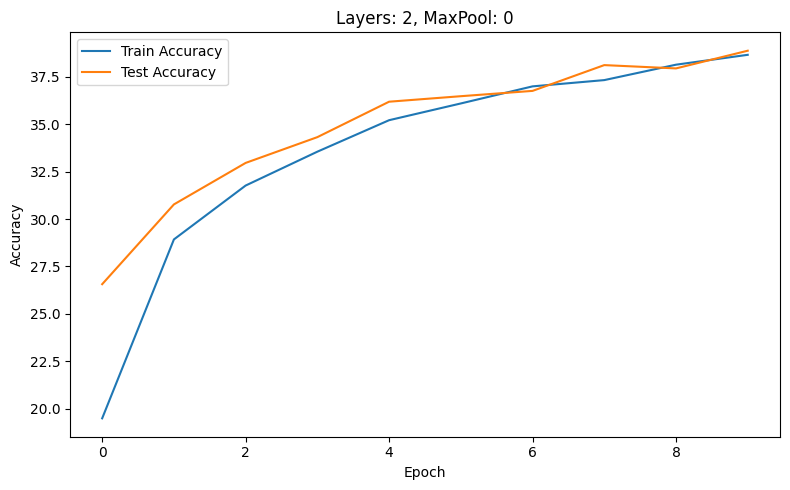

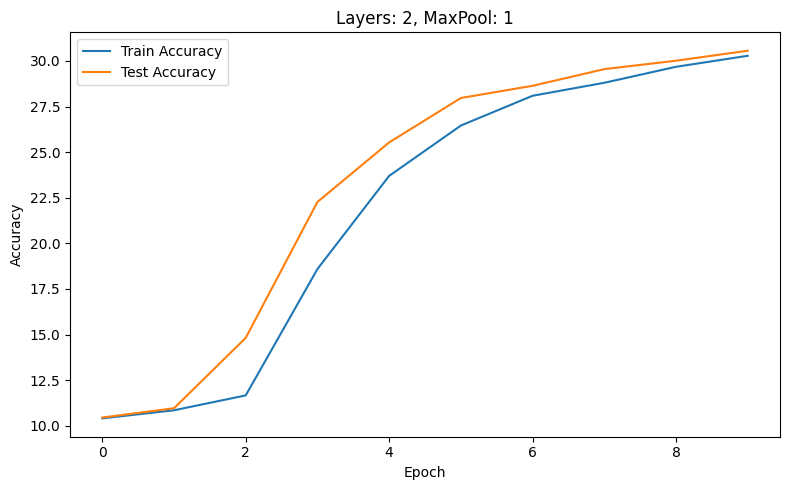

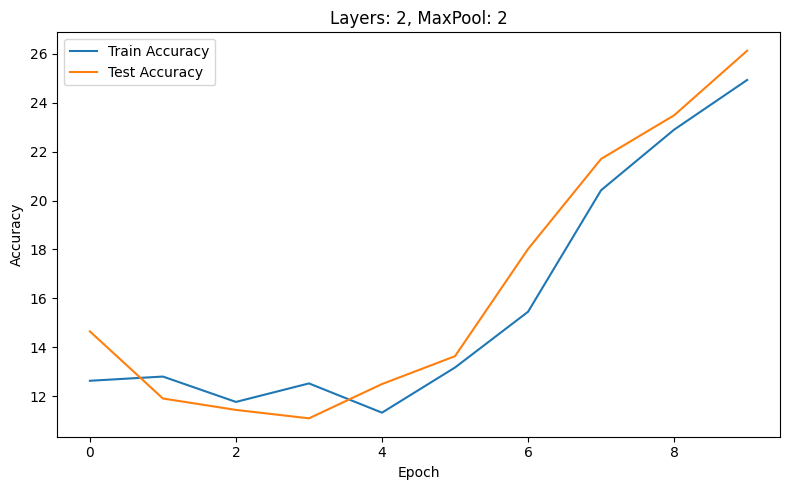

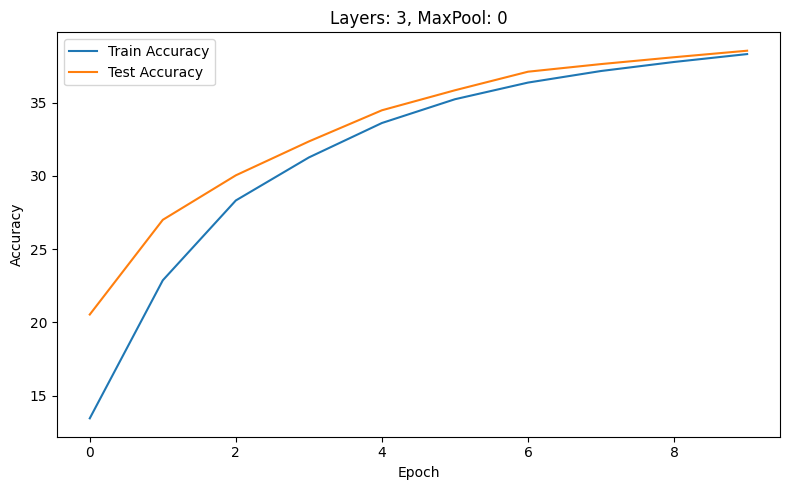

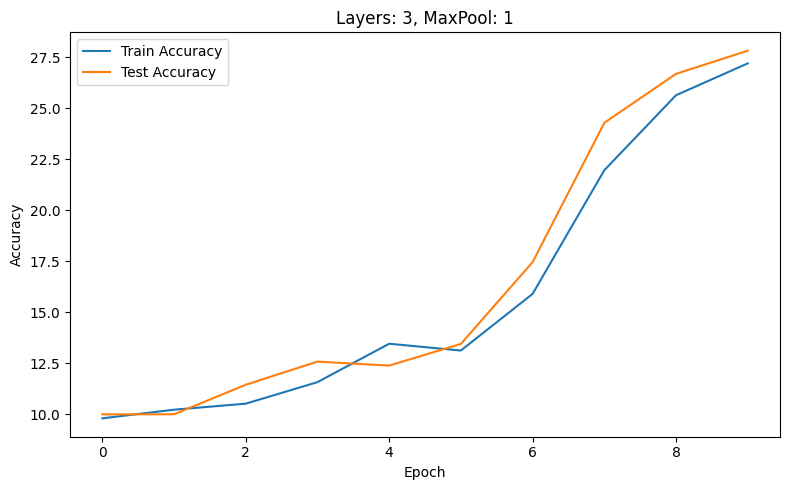

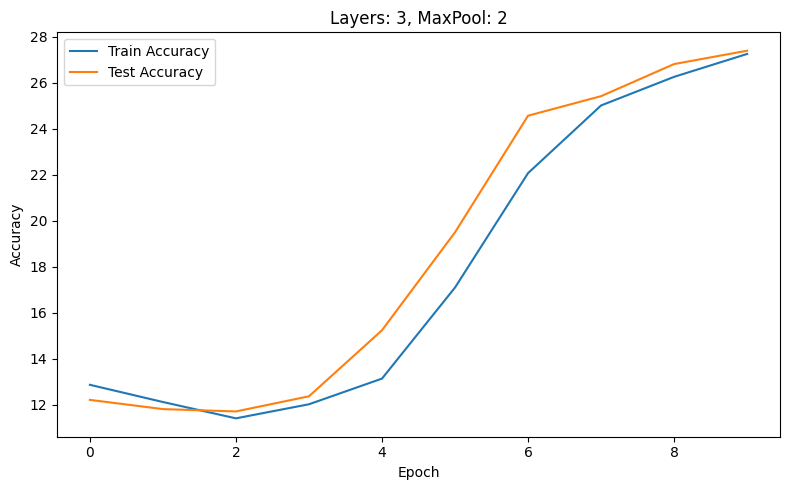

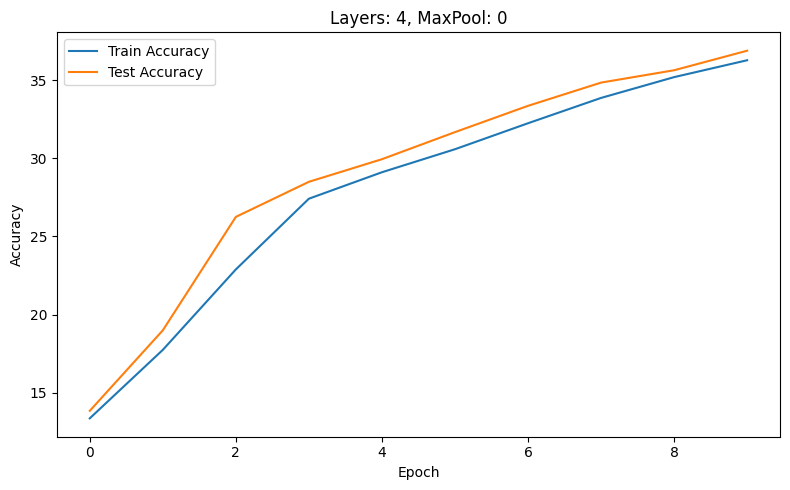

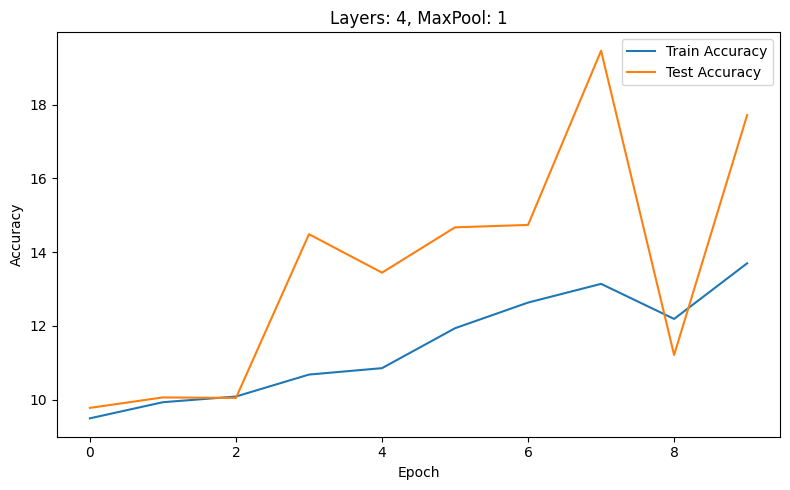

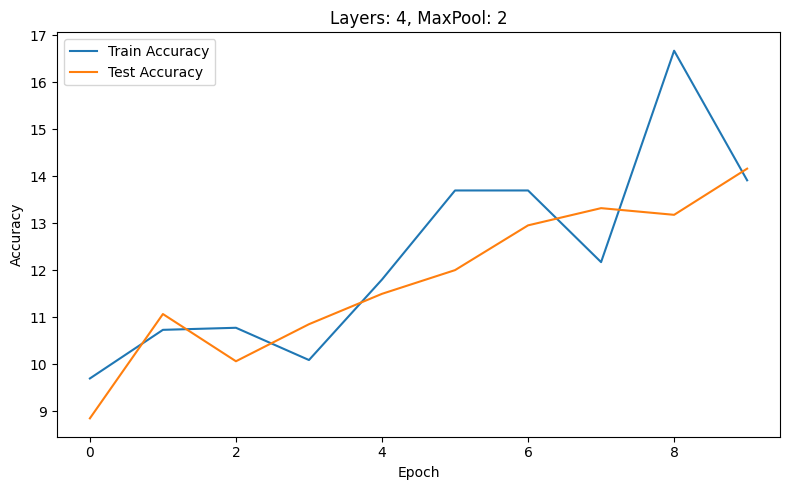

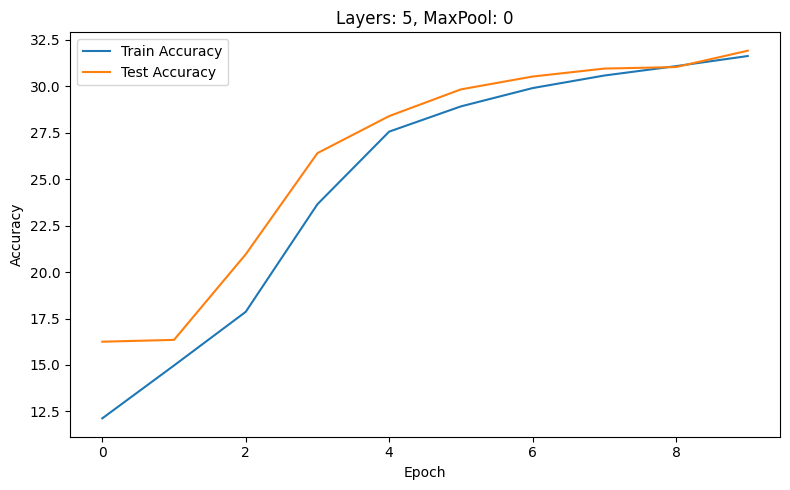

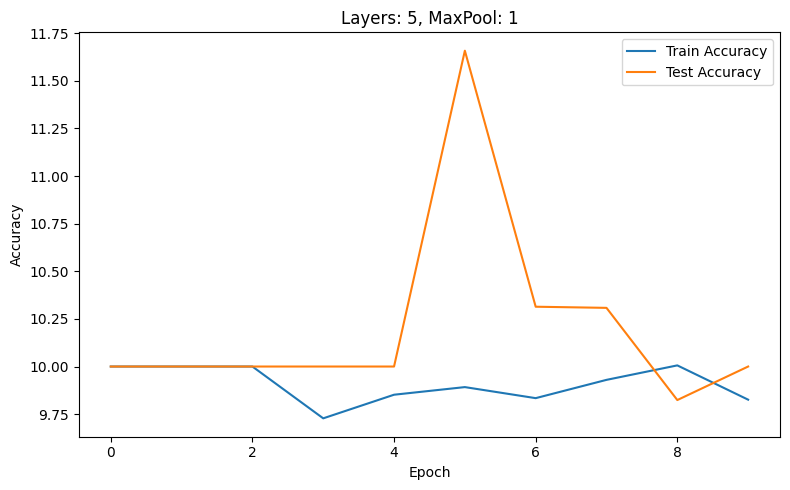

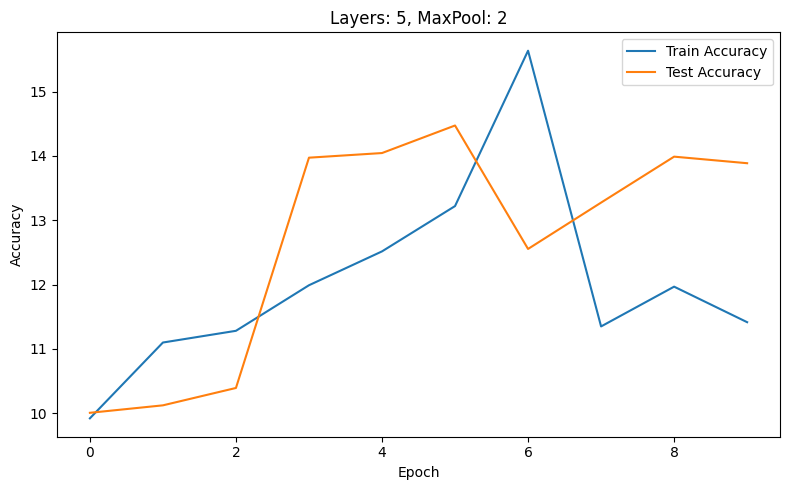

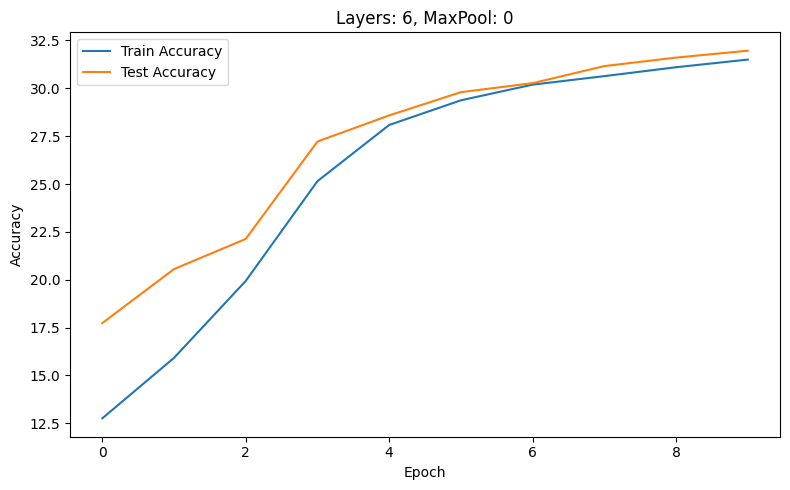

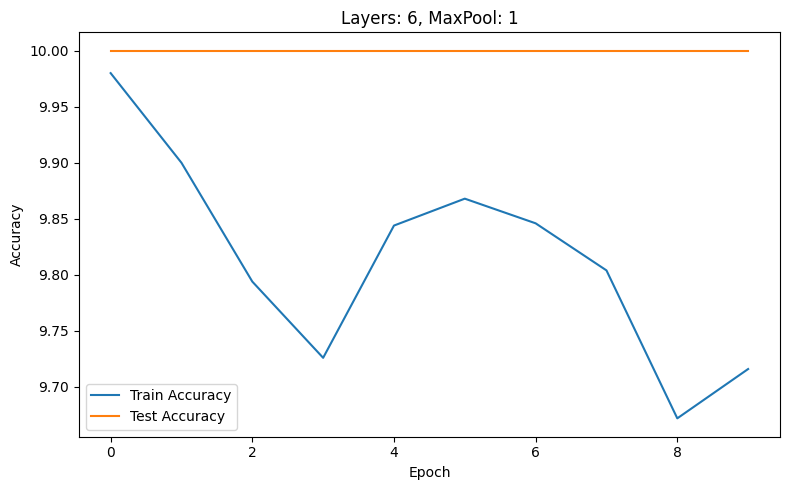

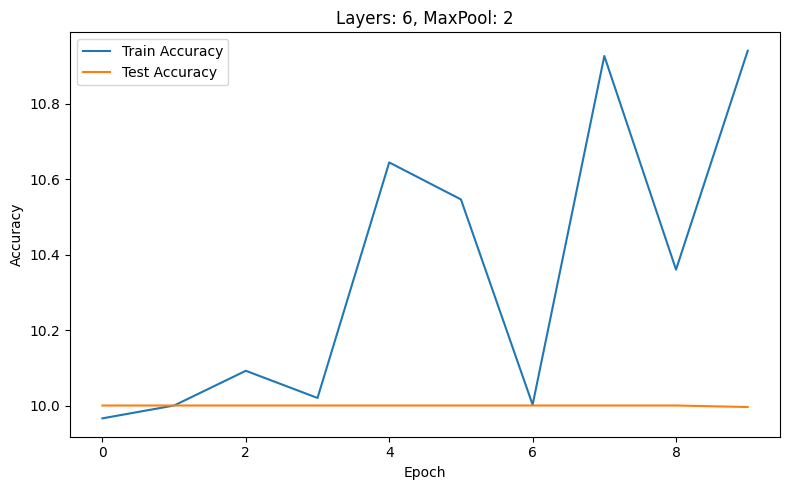

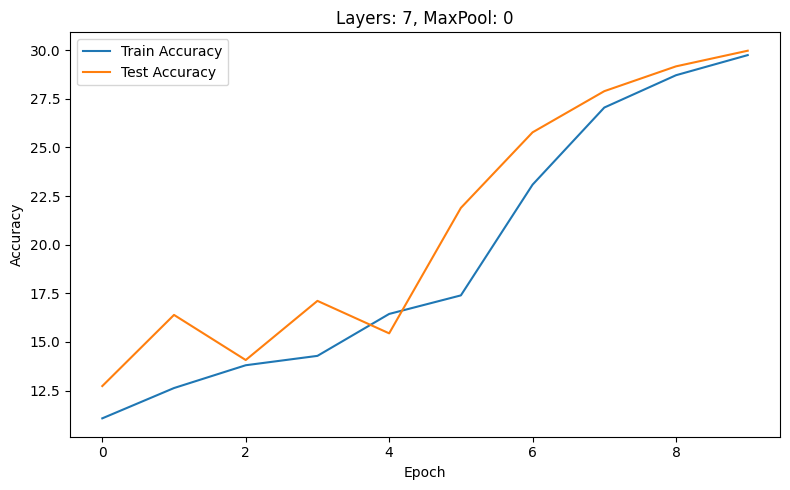

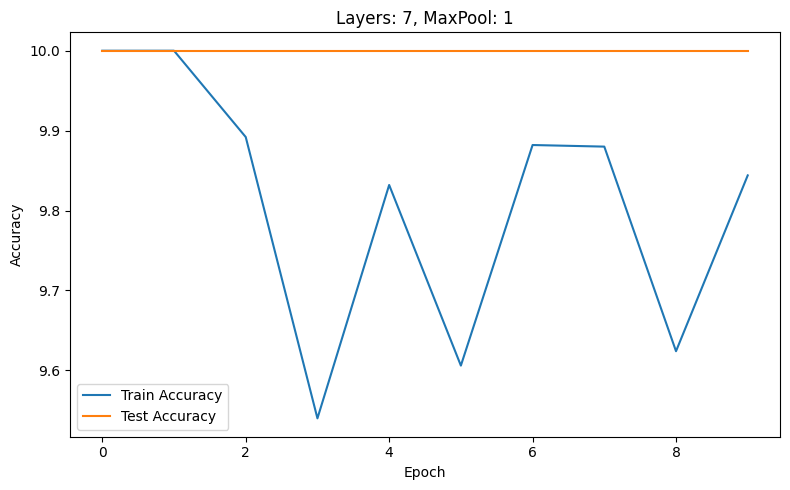

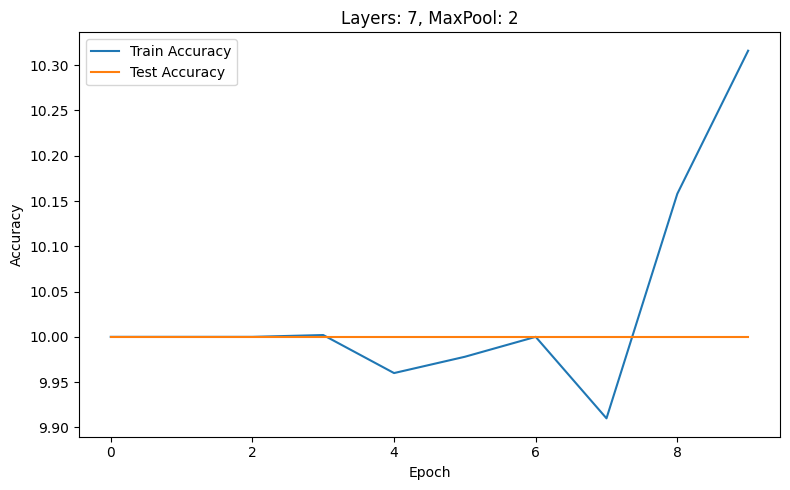

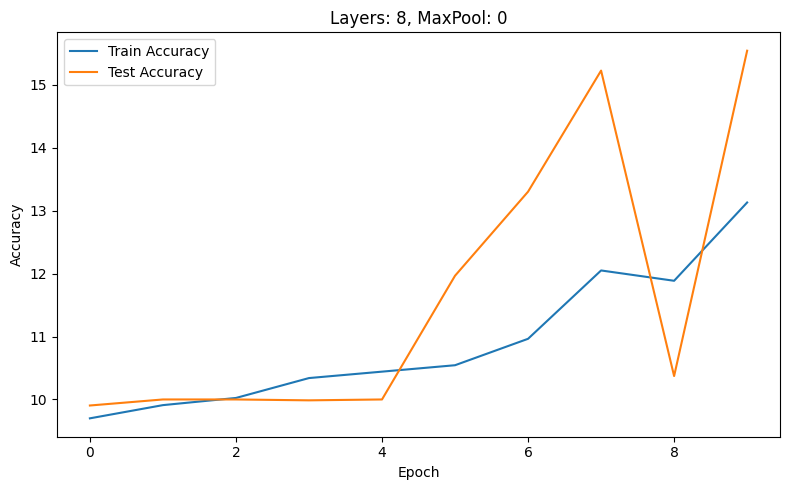

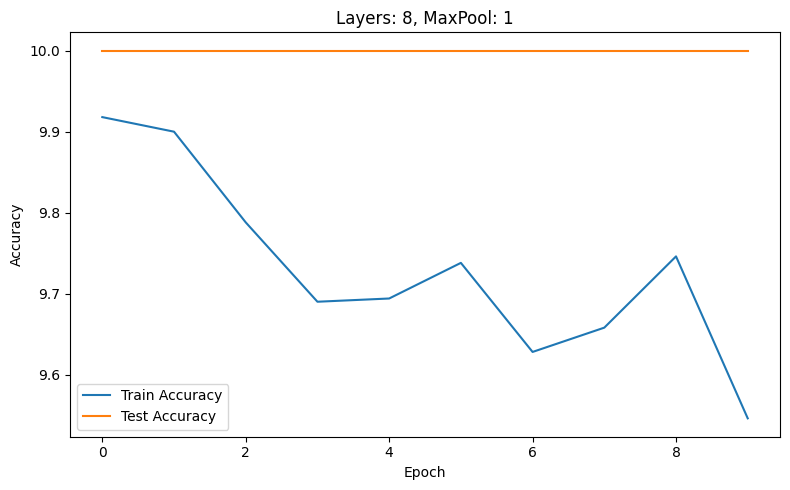

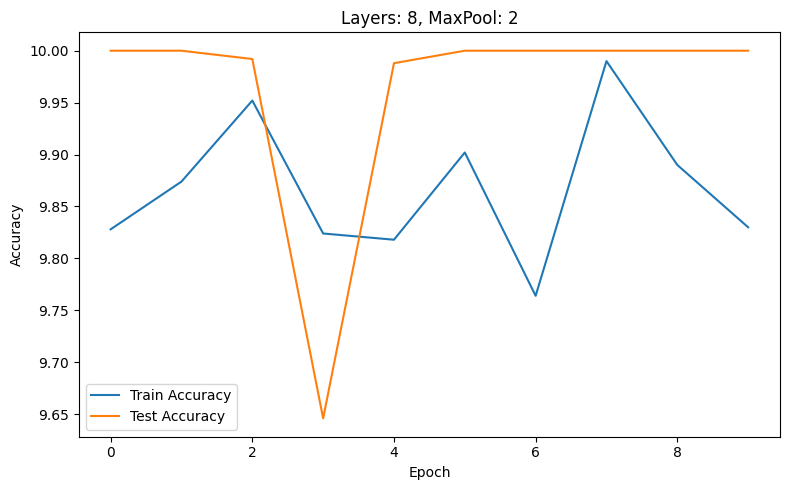

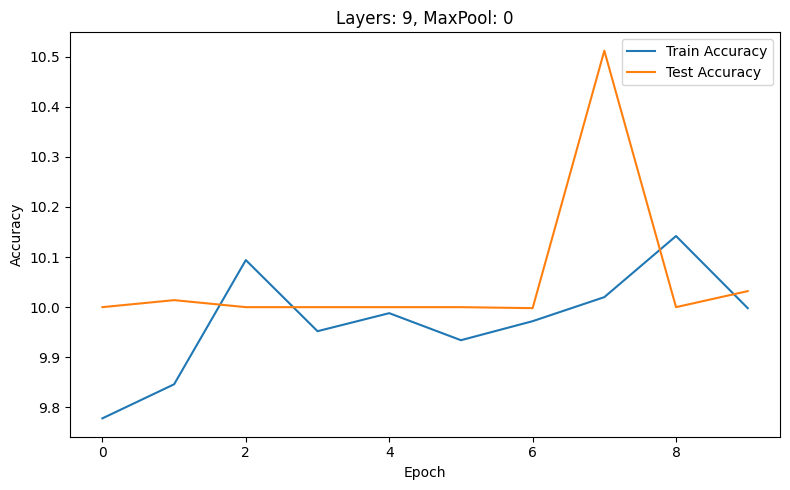

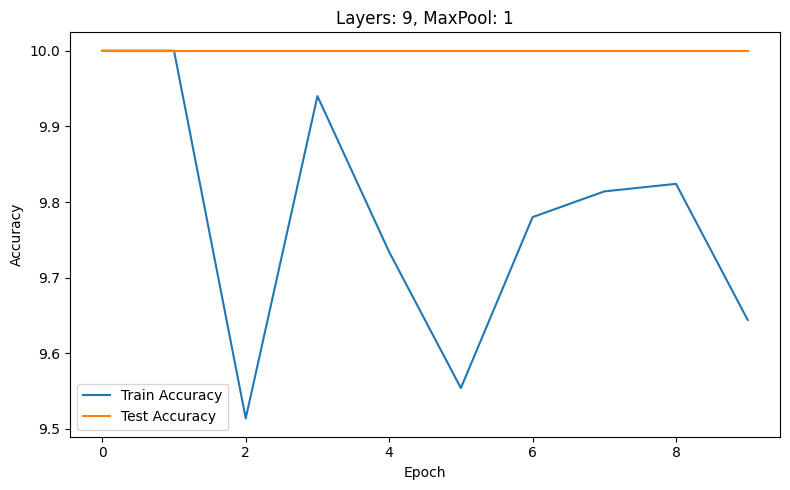

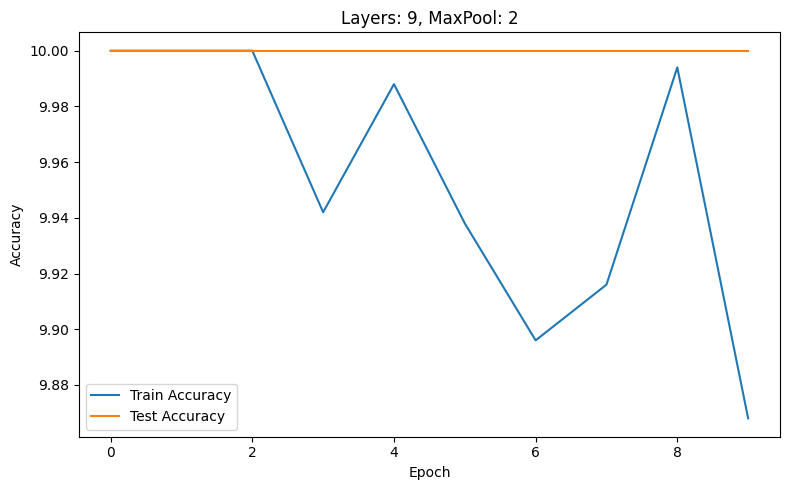

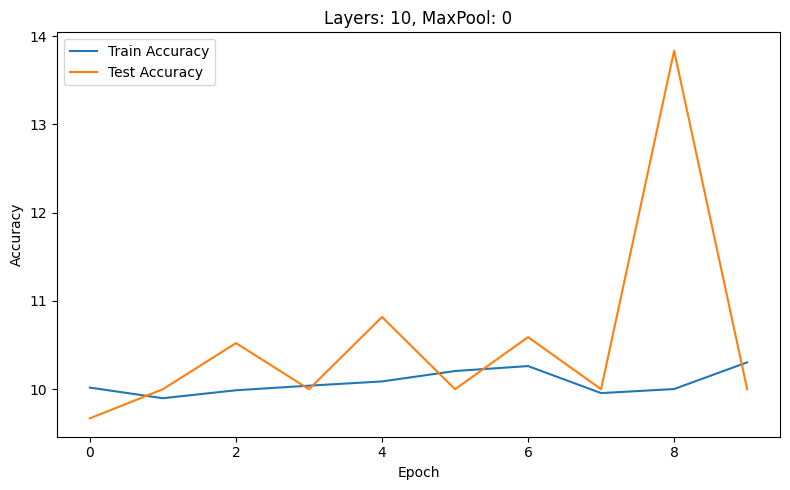

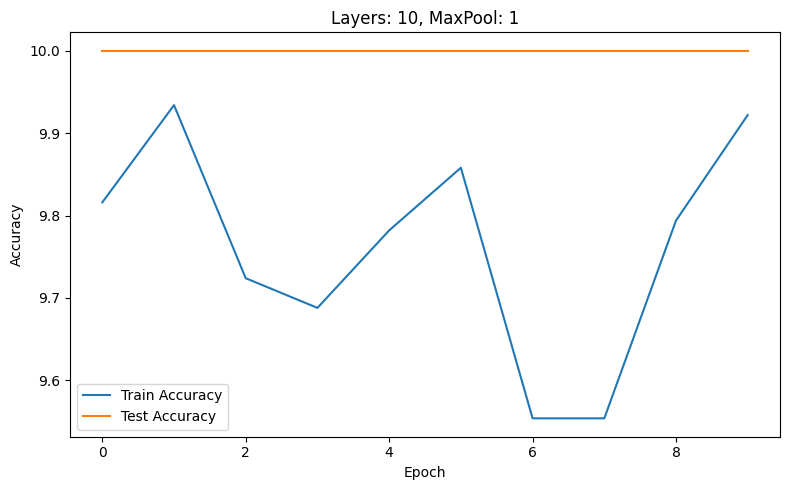

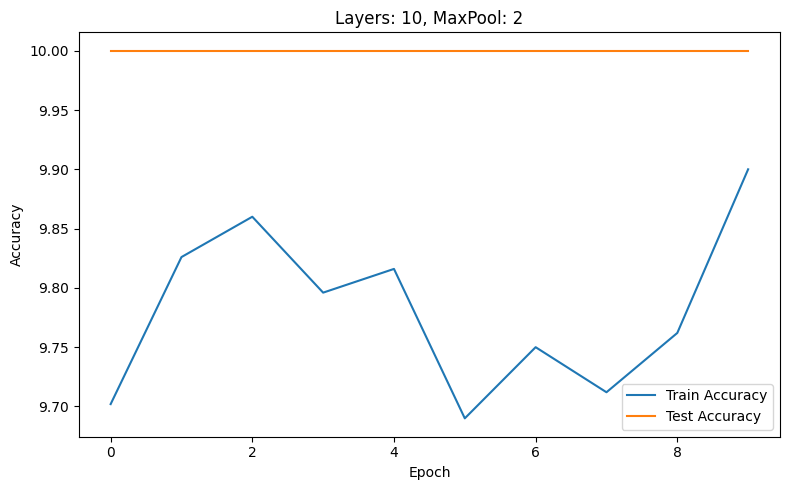

In [ ]:
# from the following plotting we see that the first model wihout max pool in 10 epochs is the best one
# i think in more training there will be another model can compete this model -> maxpooling is important to make model more robust
# but we have 10 epochs for learn that may be small not enough to learn with maxpool
# you can try use optuna instead of grid serach and show the output is still the same or not but in more epochs instead of 10 epochs
for result in results_list:
    plt.figure(figsize=(8, 5))
    label = f"Layers: {result['num_layers']}, MaxPool: {result['num_maxPooling']}"
    plt.plot(result['train_accuracy'], label='Train Accuracy')
    plt.plot(result['test_accuracy'], label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(label)
    plt.legend()
    plt.tight_layout()
    plt.show()

---

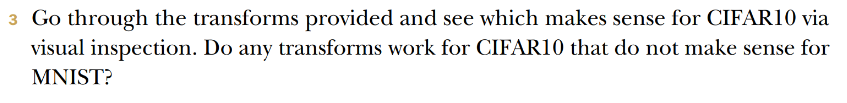

Files already downloaded and verified


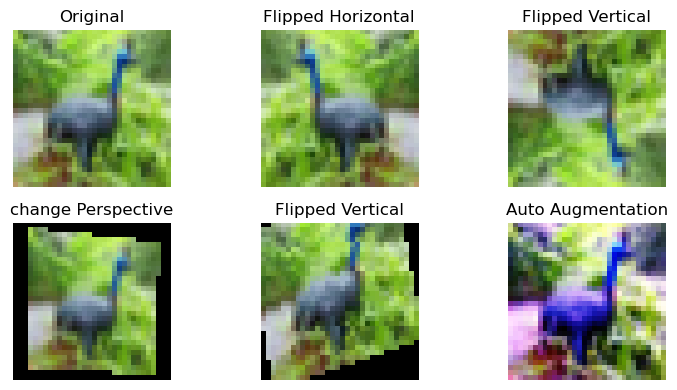

In [72]:
train_dataset = torchvision.datasets.CIFAR10("data", train=True, download=True)


fig, ax = plt.subplots(2, 3, figsize=(8, 4)) 
ax[0][0].imshow((train_dataset[6][0]))
ax[0][0].set_title("Original")
ax[0][0].axis('off')

ax[0][1].imshow(transforms.RandomHorizontalFlip(p=1.0)(train_dataset[6][0]))
ax[0][1].set_title("Flipped Horizontal")
ax[0][1].axis('off')

ax[0][2].imshow(transforms.RandomVerticalFlip(p=1.0)(train_dataset[6][0]))
ax[0][2].set_title("Flipped Vertical")
ax[0][2].axis('off')

ax[1][0].imshow(transforms.RandomPerspective(distortion_scale=0.3, p=1.0)(train_dataset[6][0]))
ax[1][0].set_title("change Perspective")
ax[1][0].axis('off')

ax[1][1].imshow(transforms.RandomAffine(degrees=(-35, 35), translate=(0.1, 0.1), shear=(-10, 10))(train_dataset[6][0]))
ax[1][1].set_title("Flipped Vertical")
ax[1][1].axis('off')

ax[1][2].imshow(transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10)(train_dataset[6][0]))
ax[1][2].set_title("Auto Augmentation")
ax[1][2].axis('off')

plt.tight_layout()
plt.show()


---